# EKF for a 2D state vector

We generalize the EKF for the noisy pendulum to predict both angular position and velocity. The filtering problem now becomes more tricky, and tuning is necessary to obtain reasonable performance.

Some recommendations are provided at the end of the example.

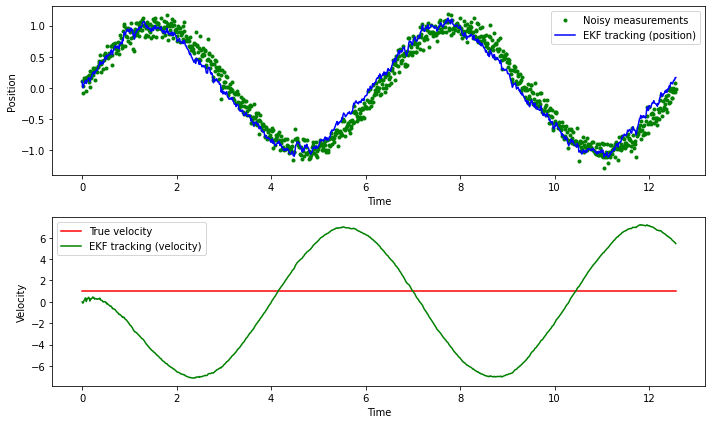

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class ExtendedKalmanFilter:
    def __init__(self, x, P, Q, R):
        """
        x: The initial state vector [position, velocity]
        P: The initial covariance matrix
        Q: The process noise covariance matrix
        R: The measurement noise covariance matrix
        """
        self.x = x
        self.P = P
        self.Q = Q
        self.R = R

    def predict(self, dt):
        """
        Predict the next state of the system using the nonlinear process model.
        """
        # Nonlinear process model (pendulum equations)
        theta, theta_dot = self.x
        theta_predict = theta + theta_dot * dt
        theta_dot_predict = theta_dot - (g / l) * np.sin(theta) * dt

        self.x = np.array([theta_predict, theta_dot_predict])

        # Jacobian of the process model (A matrix)
        A = np.array([[1, dt],
                      [-(g / l) * np.cos(theta) * dt, 1]])

        # Update the covariance matrix
        self.P = np.dot(np.dot(A, self.P), A.T) + self.Q

    def update(self, y):
        """
        Update the state estimate using the nonlinear measurement model.
        """
        # Nonlinear measurement model (position measurement)
        theta, _ = self.x
        y_predict = np.sin(theta)

        # Jacobian of the measurement model (H matrix)
        H = np.array([[np.cos(theta), 0]])

        # Calculate the measurement residual
        residual = y - y_predict

        # Calculate the Kalman gain
        S = np.dot(np.dot(H, self.P), H.T) + self.R
        K = np.dot(np.dot(self.P, H.T), np.linalg.inv(S))

        # Update the state estimate and covariance matrix
        self.x = self.x + np.dot(K, residual)
        self.P = self.P - np.dot(np.dot(K, H), self.P)

# Define the parameters of the pendulum
g = 9.81  # m/s^2
l = 1  # m

# Initialize the state vector [position, velocity]
x = np.array([0, 0])  # Initial state: [position, velocity]

# Initialize the covariance matrix
P = np.diag([1, 1])  # Initial covariance

# Define the process noise covariance matrix
Q = np.diag([0.001, 0.001])  # Variance of the process noise

# Define the measurement noise covariance matrix
R = np.array([0.01])  # Variance of the measurement noise

# Initialize the Extended Kalman filter
ekf = ExtendedKalmanFilter(x, P, Q, R)

# Simulate for 2 to 3 periods
T = np.linspace(0, 2 * np.pi * 2, num=1000)  # Time vector
measurements = []
x_hat = []  # To store the filtered state estimates
for t in T:
    # Calculate the true state of the pendulum
    theta_true = np.sin(t)
    theta_dot_true = np.cos(t)  # True angular velocity

    # Add noise to the measurement
    y = np.array([theta_true]) + np.random.randn() * np.sqrt(R)

    measurements.append(y)

    # Run the Extended Kalman filter
    dt = T[1] - T[0]
    ekf.predict(dt)
    ekf.update(y)
    x_hat.append(ekf.x)  # Store the filtered state estimate

# Convert the lists to NumPy arrays for plotting
measurements = np.array(measurements)
x_hat = np.array(x_hat)

# Plot the noisy measurements and the EKF tracking result for both position and velocity
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(T, measurements, 'g.', label='Noisy measurements')
plt.plot(T, x_hat[:, 0], 'b-', label='EKF tracking (position)')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(T, theta_dot_true * np.ones_like(T), 'r-', label='True velocity')
plt.plot(T, x_hat[:, 1], 'g-', label='EKF tracking (velocity)')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()

plt.tight_layout()
plt.show()


The position is well tracked, but the velocity not at all. There are different ways to fix this--see below.

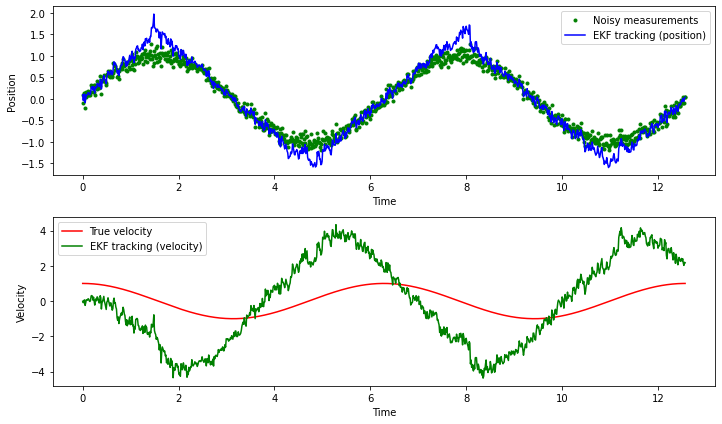

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class ExtendedKalmanFilter:
    def __init__(self, x, P, Q, R):
        """
        x: The initial state vector [position, velocity]
        P: The initial covariance matrix
        Q: The process noise covariance matrix
        R: The measurement noise covariance matrix
        """
        self.x = x
        self.P = P
        self.Q = Q
        self.R = R

    def predict(self, dt):
        """
        Predict the next state of the system using the nonlinear process model.
        """
        # Nonlinear process model (pendulum equations)
        theta, theta_dot = self.x
        theta_predict = theta + theta_dot * dt
        theta_dot_predict = theta_dot - (g / l) * np.sin(theta) * dt

        self.x = np.array([theta_predict, theta_dot_predict])

        # Jacobian of the process model (A matrix)
        A = np.array([[1, dt],
                      [-(g / l) * np.cos(theta) * dt, 1]])

        # Update the covariance matrix
        self.P = np.dot(np.dot(A, self.P), A.T) + self.Q

    def update(self, y):
        """
        Update the state estimate using the nonlinear measurement model.
        """
        # Nonlinear measurement model (position measurement)
        theta, _ = self.x
        y_predict = np.sin(theta)

        # Jacobian of the measurement model (H matrix)
        H = np.array([[np.cos(theta), 0]])

        # Calculate the measurement residual
        residual = y - y_predict

        # Calculate the Kalman gain
        S = np.dot(np.dot(H, self.P), H.T) + self.R
        K = np.dot(np.dot(self.P, H.T), np.linalg.inv(S))

        # Update the state estimate and covariance matrix
        self.x = self.x + np.dot(K, residual)
        self.P = self.P - np.dot(np.dot(K, H), self.P)

# Define the parameters of the pendulum
g = 9.81  # m/s^2
l = 1  # m

# Initialize the state vector [position, velocity]
x = np.array([0, 0])  # Initial state: [position, velocity]

# Initialize the covariance matrix
P = np.diag([1, 1])  # Initial covariance

# Define the process noise covariance matrix
Q = np.diag([0.001, 0.001])  # Variance of the process noise

# Define the measurement noise covariance matrix
R = np.array([0.01])  # Variance of the measurement noise


# For improved velocity tracking, one might try
# increasing the process noise covariance matrix
Q = np.diag([0.01, 0.1])  # Increased process noise for velocity
# Initialize the covariance matrix
P = np.diag([1, 1])  # Initial covariance


# Initialize the Extended Kalman filter
ekf = ExtendedKalmanFilter(x, P, Q, R)

# Simulate for 2 to 3 periods
T = np.linspace(0, 2 * np.pi * 2, num=1000)  # Time vector
measurements = []
x_hat = []  # To store the filtered state estimates
true_velocity = []  # To store the true angular velocity
for t in T:
    # Calculate the true state of the pendulum
    theta_true = np.sin(t)
    theta_dot_true = np.cos(t)  # True angular velocity

    # Add noise to the measurement
    y = np.array([theta_true]) + np.random.randn() * np.sqrt(R)

    measurements.append(y)

    # Run the Extended Kalman filter
    dt = T[1] - T[0]
    ekf.predict(dt)
    ekf.update(y)
    x_hat.append(ekf.x)  # Store the filtered state estimate
    true_velocity.append(theta_dot_true)

# Convert the lists to NumPy arrays for plotting
measurements = np.array(measurements)
x_hat = np.array(x_hat)
true_velocity = np.array(true_velocity)

# Plot the noisy measurements and the EKF tracking result for both position and velocity
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(T, measurements, 'g.', label='Noisy measurements')
plt.plot(T, x_hat[:, 0], 'b-', label='EKF tracking (position)')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(T, true_velocity, 'r-', label='True velocity')
plt.plot(T, x_hat[:, 1], 'g-', label='EKF tracking (velocity)')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()

plt.tight_layout()
plt.show()


To improve the tracking of velocity by the Extended Kalman Filter (EKF), you can consider the following adjustments:

- __Increase Process Noise (Q)__: Increase the process noise covariance matrix Q. A higher value for the process noise indicates that you trust the measurements more than the model predictions. It allows the filter to adapt more quickly to changes in velocity.

- __Tune Initial Covariance (P)__: Adjust the initial covariance matrix P. A smaller initial covariance can provide more weight to the initial estimate and improve tracking initially.

- __Measurement Model__: Ensure that the measurement model (nonlinear function) accurately represents the relationship between the observed measurements and the state variables (position and velocity). If the model is not accurate, the EKF might struggle to estimate the velocity correctly.

- __Iterative Tuning__: Consider iterative tuning of the process and measurement noise covariance matrices (Q and R) and the initial covariance (P). Start with conservative values and gradually increase or decrease them until you achieve the desired tracking performance.

- __Observability__: Ensure that the system is observable. If certain states are not directly observable from the measurements, consider using additional sensors or designing a more informative measurement model.

- __Nonlinearities__: Be aware that the EKF linearizes the system dynamics and measurement equations. If the system is highly nonlinear, the EKF might not perform optimally. In such cases, you might explore other filtering methods like the Unscented Kalman Filter (UKF) or the Particle Filter.